Comparison with Monocle3
========================


## Setting up environment modules and basic settings

### Generating the environment

The following needs to be run in the command-line

```bash
mamba create -n scFates_bench -c rapidsai -c nvidia -c conda-forge -c r -c bioconda \
    python=3.8 r-mgcv rpy2=3.4.3 r-monocle3 jupyter ipykernel cuml=22.06 cugraph=22.06 cudatoolkit=11.0 anndata2ri -y
    
mamba activate scFates_bench
pip install scFates anndata2ri
python -m ipykernel install --user --name scFates --display-name "scFates"
``` 

### Loading libraries

In [1]:
import os,sys
import numpy as np
os.environ["R_HOME"]="/".join(
    np.array(sys.executable.split("/"))[:-2]
)+"/lib/R/"

In [2]:
import scFates as scf
import scanpy as sc
import pandas as pd
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

### Loading processed Monocle3 data

In [3]:
%%R
suppressMessages(library(monocle3))
load("data/cds.RData")
cds

class: cell_data_set 
dim: 20222 6188 
metadata(2): cds_version citations
assays(1): counts
rownames(20222): WBGene00010957 WBGene00010958 ... WBGene00021594
  WBGene00007064
rowData names(3): id gene_short_name num_cells_expressed
colnames(6188): AAACCTGCAAGACGTG-300.1.1 AAACCTGGTGTGAATA-300.1.1 ...
  TGCGGGTAGTACTTGC-b02 TTTGTCAAGTACACCT-b02
colData names(19): cell n.umi ... bg.b01.loading bg.b02.loading
reducedDimNames(3): PCA Aligned UMAP
altExpNames(0):


## Tree learning benchmarks

### Monocle3

In [4]:
%%R -o duration_monocle3
duration_monocle3=c()
for (i in 1:10){
    set.seed(42)
    start_time <- Sys.time()
    cds <- learn_graph(cds,learn_graph_control=list(ncenter=1000),verbose=T)
    end_time <- Sys.time()
    duration <- end_time - start_time
    duration_monocle3 <- append(duration_monocle3,as.numeric(duration))
}


Running louvain iteration  1 ...
  -Number of clusters: 40 
  |======================================================================| 100%
Running louvain iteration  1 ...
  -Number of clusters: 40 
  |======================================================================| 100%
Running louvain iteration  1 ...
  -Number of clusters: 40 
  |======================================================================| 100%
Running louvain iteration  1 ...
  -Number of clusters: 40 
  |======================================================================| 100%
Running louvain iteration  1 ...
  -Number of clusters: 40 
  |======================================================================| 100%
Running louvain iteration  1 ...
  -Number of clusters: 40 
  |======================================================================| 100%
Running louvain iteration  1 ...
  -Number of clusters: 40 
  |======================================================================| 100%
Running louvain iter

### scFates (CPU)

In [5]:
%%R -o UMAP -o proj -o B -o cnts -o genes -o cells
UMAP=reducedDim(cds,"UMAP")
proj=t(cds@principal_graph_aux$UMAP$dp_mst)
B=cds@principal_graph_aux$UMAP$stree

cnts=cds@assays@data$counts
genes=rownames(cnts)
cells=colnames(cnts)

In [6]:
adata=sc.AnnData(cnts).T
adata.var_names=genes
adata.obs_names=cells
adata.obsm["X_umap"]=UMAP

/tmp/ipykernel_1235907/862670603.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata=sc.AnnData(cnts).T


In [7]:
import time
duration_scFates=list()
scf.settings.verbosity=2
for i in range(10):
    start = time.time()
    scf.tl.tree(adata,Nodes=1000,use_rep="X_umap",ppt_sigma=.2,ppt_lambda=100,device="cpu",seed=42)
    end = time.time()
    duration_scFates.append(end - start)
duration_scFates=np.array(duration_scFates)

inferring a principal tree
    fitting: 100%|██████████| 50/50 [00:43<00:00,  1.16it/s]
    not converged (error: 0.04965489664099719)
    finished (0:00:43)
inferring a principal tree
    fitting: 100%|██████████| 50/50 [00:33<00:00,  1.48it/s]
    not converged (error: 0.04965489664099719)
    finished (0:00:34)
inferring a principal tree
    fitting: 100%|██████████| 50/50 [00:35<00:00,  1.42it/s]
    not converged (error: 0.04965489664099719)
    finished (0:00:35)
inferring a principal tree
    fitting: 100%|██████████| 50/50 [00:28<00:00,  1.76it/s]
    not converged (error: 0.04965489664099719)
    finished (0:00:28)
inferring a principal tree
    fitting: 100%|██████████| 50/50 [00:38<00:00,  1.30it/s]
    not converged (error: 0.04965489664099719)
    finished (0:00:38)
inferring a principal tree
    fitting: 100%|██████████| 50/50 [00:42<00:00,  1.19it/s]
    not converged (error: 0.04965489664099719)
    finished (0:00:42)
inferring a principal tree
    fitting: 100%|███████

### scFates (GPU)

In [8]:
scf.settings.verbosity=2
duration_scFates_gpu=list()
for i in range(10):
    start = time.time()
    scf.tl.tree(adata,Nodes=1000,use_rep="X_umap",ppt_sigma=.2,ppt_lambda=100,device="gpu",seed=42)
    end = time.time()
    duration_scFates_gpu.append(end - start)
duration_scFates_gpu=np.array(duration_scFates_gpu)

inferring a principal tree
    fitting: 100%|██████████| 50/50 [00:14<00:00,  3.56it/s]
    inference not converged (error: 0.04965489664107294)
    finished (0:00:18)
inferring a principal tree
    fitting: 100%|██████████| 50/50 [00:03<00:00, 12.54it/s]
    inference not converged (error: 0.04965489664107294)
    finished (0:00:04)
inferring a principal tree
    fitting: 100%|██████████| 50/50 [00:04<00:00, 12.32it/s]
    inference not converged (error: 0.04965489664107294)
    finished (0:00:04)
inferring a principal tree
    fitting: 100%|██████████| 50/50 [00:04<00:00, 12.27it/s]
    inference not converged (error: 0.04965489664107294)
    finished (0:00:04)
inferring a principal tree
    fitting: 100%|██████████| 50/50 [00:04<00:00, 12.31it/s]
    inference not converged (error: 0.04965489664107294)
    finished (0:00:04)
inferring a principal tree
    fitting: 100%|██████████| 50/50 [00:04<00:00, 12.32it/s]
    inference not converged (error: 0.04965489664107294)
    finished (0

### Plotting results

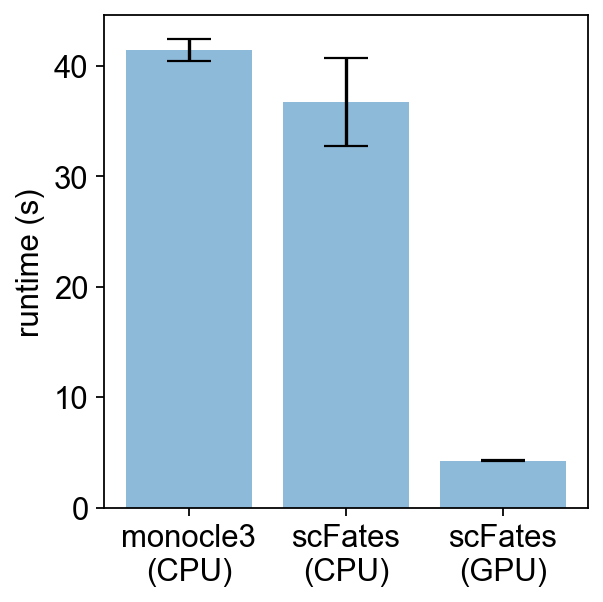

In [12]:
# Build the plot
sc.set_figure_params()
scf.set_figure_pubready()
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.bar(range(3),[np.mean(duration_monocle3[1:]),
                 np.mean(duration_scFates[1:]),
                 np.mean(duration_scFates_gpu[1:])], 
             yerr=[np.std(duration_monocle3[1:]),
                 np.std(duration_scFates[1:]),
                 np.std(duration_scFates_gpu[1:])], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel("runtime (s)")
ax.set_xticks([0,1,2])
ax.set_xticklabels(["monocle3\n(CPU)","scFates\n(CPU)","scFates\n(GPU)"])
ax.grid(False)
# Save the figure and show
plt.tight_layout()
plt.savefig("figures/Moncole3_runtime.pdf")

### Comparing trees

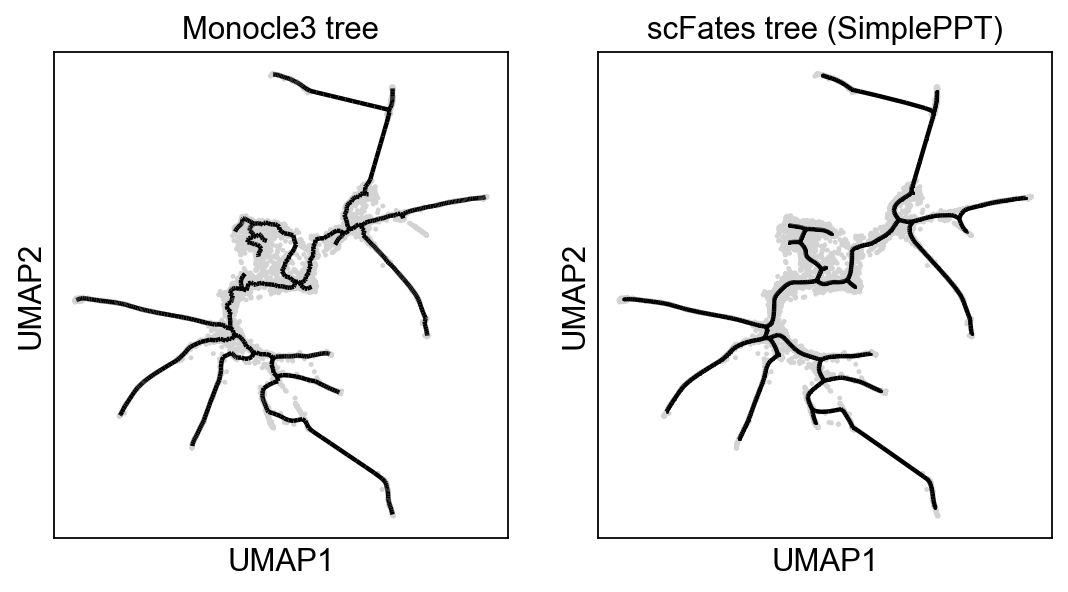

In [13]:
import numpy as np
import igraph
import matplotlib
import matplotlib.pyplot as plt
sc.set_figure_params()
scf.set_figure_pubready()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))

sc.pl.umap(adata,show=False,ax=ax1)
al = np.array(
    igraph.Graph.Adjacency((B.A > 0).tolist(), mode="undirected").get_edgelist()
)
segs = al.tolist()
vertices = proj.tolist()
lines = [[tuple(vertices[j]) for j in i] for i in segs]
lc = matplotlib.collections.LineCollection(
    lines, colors="k", linewidths=2, alpha=1, rasterized=True
)
ax1.add_collection(lc)
ax1.set_title("Monocle3 tree")

scf.pl.graph(adata,size_nodes=.1,forks=False,tips=False,show=False,ax=ax2,title="scFates tree (SimplePPT)")

plt.savefig("figures/Monocle3_tree.pdf",dpi=300)

## Comparing feature selection

### Root selection and cell ordering

    graph cleaned


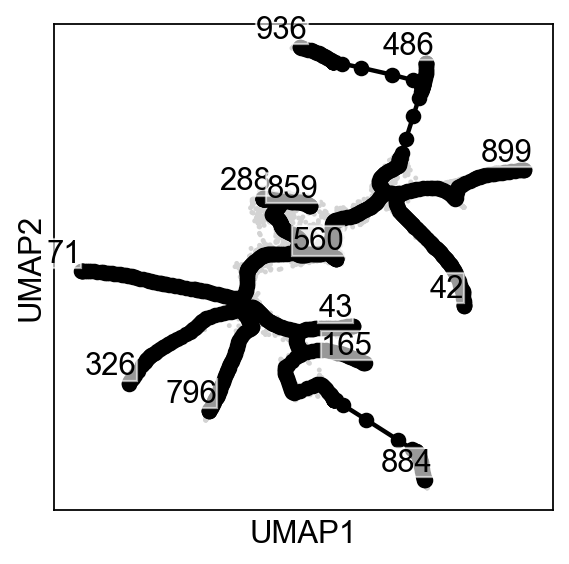

In [14]:
scf.tl.cleanup(adata,minbranchlength=20)
scf.pl.graph(adata,forks=False)

In [15]:
scf.tl.root(adata,560)

node 560 selected as a root


In [16]:
scf.tl.pseudotime(adata)

projecting cells onto the principal graph
    finished (0:00:08)


In [17]:
%%R -o psdt
cds = order_cells(cds,root_pr_nodes = "Y_588")
psdt = cds@principal_graph_aux$UMAP$pseudotime

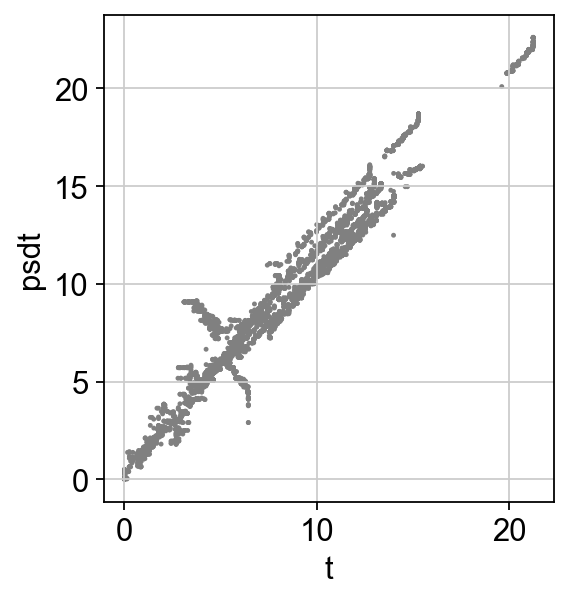

In [18]:
adata.obs["psdt"]=psdt
sc.pl.scatter(adata,x="t",y="psdt")

In [19]:
sc.pp.normalize_total(adata,target_sum=1e6)
sc.pp.log1p(adata,base=10)

### Monocle3 (Moran's I)

In [20]:
%%R -o duration_monocle3
duration_monocle3 = c()
for (i in 1:10){
    set.seed(42)
    start_time <- Sys.time()
    pr_test_res = graph_test(cds,neighbor_graph="principal_graph", cores=40)
    end_time <- Sys.time()
    duration <- end_time - start_time
    duration_monocle3 <- append(duration_monocle3,as.numeric(duration))
}

  |=======================================================| 100%, Elapsed 00:19
  |=======================================================| 100%, Elapsed 00:19
  |=======================================================| 100%, Elapsed 00:19
  |=======================================================| 100%, Elapsed 00:21
  |=======================================================| 100%, Elapsed 00:20
  |=======================================================| 100%, Elapsed 00:21
  |=======================================================| 100%, Elapsed 00:20
  |=======================================================| 100%, Elapsed 00:20
  |=======================================================| 100%, Elapsed 00:24
  |=======================================================| 100%, Elapsed 00:21


In [21]:
duration_monocle3_scFates = list()
import time
scf.settings.verbosity=2
for i in range(10):
    start = time.time()
    scf.tl.test_association_monocle3(adata,n_jobs=40)
    end = time.time()
    duration_monocle3_scFates.append(end - start)
duration_monocle3_scFates=np.array(duration_monocle3_scFates)

test features for association with the trajectory, monocle3 way
  |=======================================================| 100%, Elapsed 00:19
    found 5968 significant features (0:00:30)
test features for association with the trajectory, monocle3 way
  |=======================================================| 100%, Elapsed 00:20
    found 5968 significant features (0:00:30)
test features for association with the trajectory, monocle3 way
  |=======================================================| 100%, Elapsed 00:23
    found 5968 significant features (0:00:32)
test features for association with the trajectory, monocle3 way
  |=======================================================| 100%, Elapsed 00:19
    found 5968 significant features (0:00:27)
test features for association with the trajectory, monocle3 way
  |=======================================================| 100%, Elapsed 00:18
    found 5968 significant features (0:00:30)
test features for association with the trajectory,

In [22]:
signi_monocle3=adata.var.signi.copy()

### scFates (GAM)

In [23]:
start = time.time()
scf.tl.test_association(adata,n_jobs=40,A_cut=.1)
end = time.time()
duration_gam=(end - start)

test features for association with the trajectory
    single mapping : 100%|██████████| 20222/20222 [05:11<00:00, 64.84it/s]
    found 6016 significant features (0:05:12)


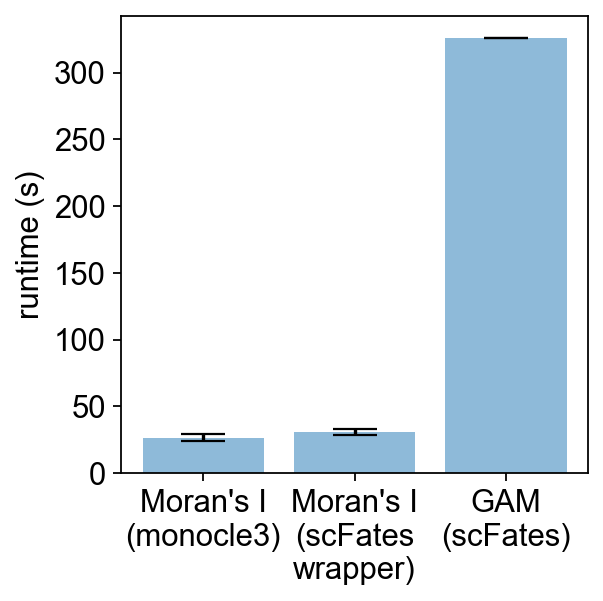

In [24]:
# Build the plot
fig, ax = plt.subplots()
ax.bar(range(3),[np.mean(duration_monocle3[1:]),
                 np.mean(duration_monocle3_scFates[1:]),
                 duration_gam], 
             yerr=[np.std(duration_monocle3[1:]),
                 np.std(duration_monocle3_scFates[1:]),
                 0], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel("runtime (s)")
ax.set_xticks([0,1,2])
ax.set_xticklabels(["Moran's I\n(monocle3)",
                              "Moran's I\n(scFates\nwrapper)",
                              "GAM\n(scFates)"])
ax.grid(False)
# Save the figure and show
plt.tight_layout()
plt.savefig("figures/Moncole3_feature_runtime.pdf")

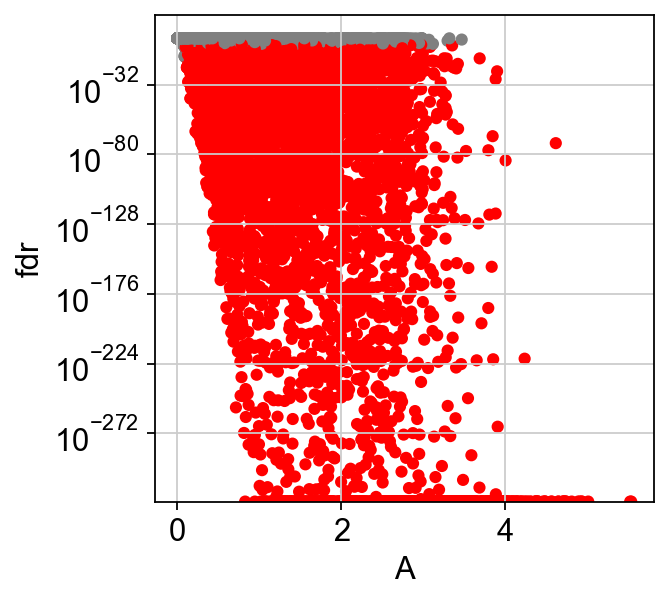

In [25]:
scf.pl.test_association(adata)

In [26]:
signi_gam=adata.var.signi.copy()

In [27]:
common=len(np.intersect1d(signi_monocle3.index[signi_monocle3],
                   signi_gam.index[signi_gam]))

spe_monocle3=len(np.intersect1d(signi_monocle3.index[signi_monocle3],
                   signi_gam.index[~signi_gam]))
spe_gam=len(np.intersect1d(signi_monocle3.index[~signi_monocle3],
                   signi_gam.index[signi_gam]))

### Plotting results

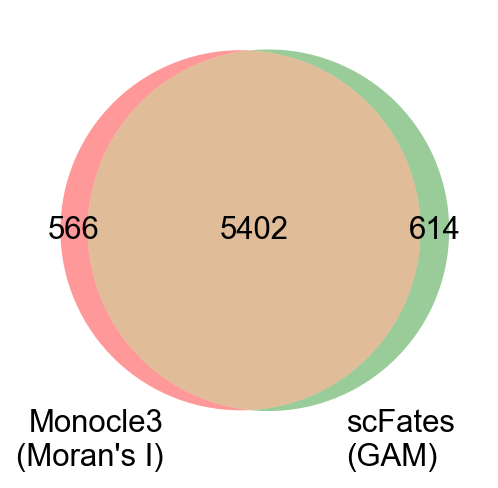

In [28]:
from matplotlib_venn import venn2
scf.set_figure_pubready()
import numpy as np
import igraph
import matplotlib
import matplotlib.pyplot as plt
sc.set_figure_params()
fig,ax=plt.subplots(figsize=(3,3),constrained_layout=True)

# Use the venn2 function
venn2(subsets = (spe_monocle3,spe_gam, common),set_labels=None,ax=ax)
ax.annotate('scFates\n(GAM)', xy=(.7,-.05),xycoords="axes fraction",ha="left")
ax.annotate("Monocle3\n(Moran's I)", xy=(.3,-.05),xycoords="axes fraction",ha="right")
#ax.set_title("Overlap of significant features\n(based on scFates tree)")
plt.savefig("figures/Monocle3_overlap.pdf",dpi=300)

In [29]:
df=adata.var

In [30]:
%%R -i df -o gene_module_df -o duration_monocle3
pr_deg_ids = row.names(subset(df, q_value < 0.05))
cds_sub <- cds[pr_deg_ids,]

duration_monocle3<-c()
for (i in 1:10){
    set.seed(42)
    start_time <- Sys.time()
    gene_module_df = find_gene_modules(cds_sub, resolution=1e-3,cores=40)
    end_time <- Sys.time()
    duration <- end_time - start_time
    duration_monocle3 <- append(duration_monocle3,as.numeric(duration))
}

In [31]:
duration_monocle3

array([15.83593988, 14.6139679 , 14.35361218, 14.42185092, 14.49838471,
       14.30822515, 14.27377105, 14.22587824, 14.28929138, 14.52127767])

In [32]:
adata=adata[:,adata.var.signi]

In [33]:
duration_scFates = list()
import time
scf.settings.verbosity=2
for i in range(10):
    start = time.time()
    scf.tl.cluster(adata)
    end = time.time()
    duration_scFates.append(end - start)
duration_scFates=np.array(duration_scFates)

Clustering features using X layer


/home/lfaure/scFates/scFates/tools/cluster.py:118: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["cluters"] = adata_s.obs.leiden


    finished (0:00:27)
Clustering features using X layer
    finished (0:00:09)
Clustering features using X layer
    finished (0:00:09)
Clustering features using X layer
    finished (0:00:09)
Clustering features using X layer
    finished (0:00:09)
Clustering features using X layer
    finished (0:00:09)
Clustering features using X layer
    finished (0:00:09)
Clustering features using X layer
    finished (0:00:09)
Clustering features using X layer
    finished (0:00:10)
Clustering features using X layer
    finished (0:00:09)


In [34]:
duration_scFates_gpu = list()
import time
scf.settings.verbosity=2
for i in range(10):
    start = time.time()
    scf.tl.cluster(adata,device="gpu")
    end = time.time()
    duration_scFates_gpu.append(end - start)
duration_scFates_gpu=np.array(duration_scFates_gpu)

Clustering features using X layer
    finished (0:00:06)
Clustering features using X layer
    finished (0:00:04)
Clustering features using X layer
    finished (0:00:05)
Clustering features using X layer
    finished (0:00:04)
Clustering features using X layer
    finished (0:00:05)
Clustering features using X layer
    finished (0:00:04)
Clustering features using X layer
    finished (0:00:04)
Clustering features using X layer
    finished (0:00:05)
Clustering features using X layer
    finished (0:00:05)
Clustering features using X layer
    finished (0:00:05)


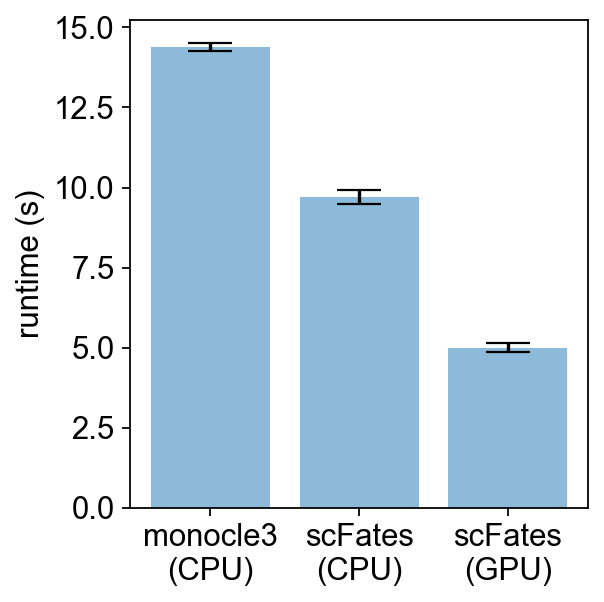

In [36]:
# Build the plot
fig, ax = plt.subplots()
ax.bar(range(3),[np.mean(duration_monocle3[1:]),
                 np.mean(duration_scFates[1:]),
                 np.mean(duration_scFates_gpu[1:])], 
             yerr=[np.std(duration_monocle3[1:]),
                 np.std(duration_scFates[1:]),
                 np.std(duration_scFates_gpu[1:])], 
       align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel("runtime (s)")
ax.set_xticks([0,1,2])
ax.set_xticklabels(["monocle3\n(CPU)",
                              "scFates\n(CPU)",
                              "scFates\n(GPU)"])
ax.grid(False)
# Save the figure and show
plt.tight_layout()
plt.savefig("figures/Moncole3_clustering_runtime.pdf")

## Figure generation

```bash
conda install -c conda-forge mscorefonts imagemagick tectonic
```

In [37]:
fname="fig3_supplementary_monocle3"
path="/".join(np.array(sys.executable.split("/"))[:-1])

In [40]:
%%bash -s $fname $path
cat<<EOF >$1.tex
\documentclass{article}
\usepackage[paperheight=155mm,paperwidth=210mm]{geometry}
\geometry{left=5mm,right=5mm,top=5mm,bottom=0mm,}

\usepackage{silence}
\WarningsOff*

\usepackage[labelfont=bf]{caption}

\usepackage[rgb]{xcolor}
\usepackage{fontspec}
\usepackage[utf8]{inputenc}
\usepackage[T1]{fontenc}
\usepackage{graphicx}
\usepackage[export]{adjustbox}

\begin{document}
\setmainfont{Arial}

\noindent
\large

\fontsize{12pt}{12pt}\selectfont

\raggedright \begin{minipage}[!ht]{0.64\textwidth}
\raggedright \textbf{A} Comparison of generated trees\\
\raggedright \includegraphics[width=\textwidth]{figures/Monocle3_tree.pdf}
\end{minipage}\hfill
\raggedright \begin{minipage}[!ht]{0.36\textwidth}
\raggedright \textbf{B} Overlap of significant features\\
\includegraphics[width=\textwidth]{figures/Monocle3_overlap.pdf}
\end{minipage}\hfill

\raggedright \begin{minipage}[t]{0.32\textwidth}
\raggedright \textbf{C} Tree inference runtime\\
\raggedright \includegraphics[width=\textwidth]{figures/Moncole3_runtime.pdf}
\end{minipage}\hfill
\raggedright \begin{minipage}[t]{0.34\textwidth}
\raggedright \textbf{D} Feature testing runtime\\
\includegraphics[width=\textwidth]{figures/Moncole3_feature_runtime.pdf}
\end{minipage}\hfill
\raggedright \begin{minipage}[t]{0.32\textwidth}
\raggedright \textbf{E} Feature clustering runtime\\
\includegraphics[width=\textwidth]{figures/Moncole3_clustering_runtime.pdf}
\end{minipage}\hfill

\clearpage
EOF
echo "\end{document}" >> $1.tex

$2/tectonic -c minimal $1.tex

$2/identify $1.pdf

$2/convert -flatten -density 300 $1.pdf $1.jpg

fig3_supplementary_monocle3.pdf PDF 612x792 612x792+0+0 16-bit sRGB 3054B 0.000u 0:00.000


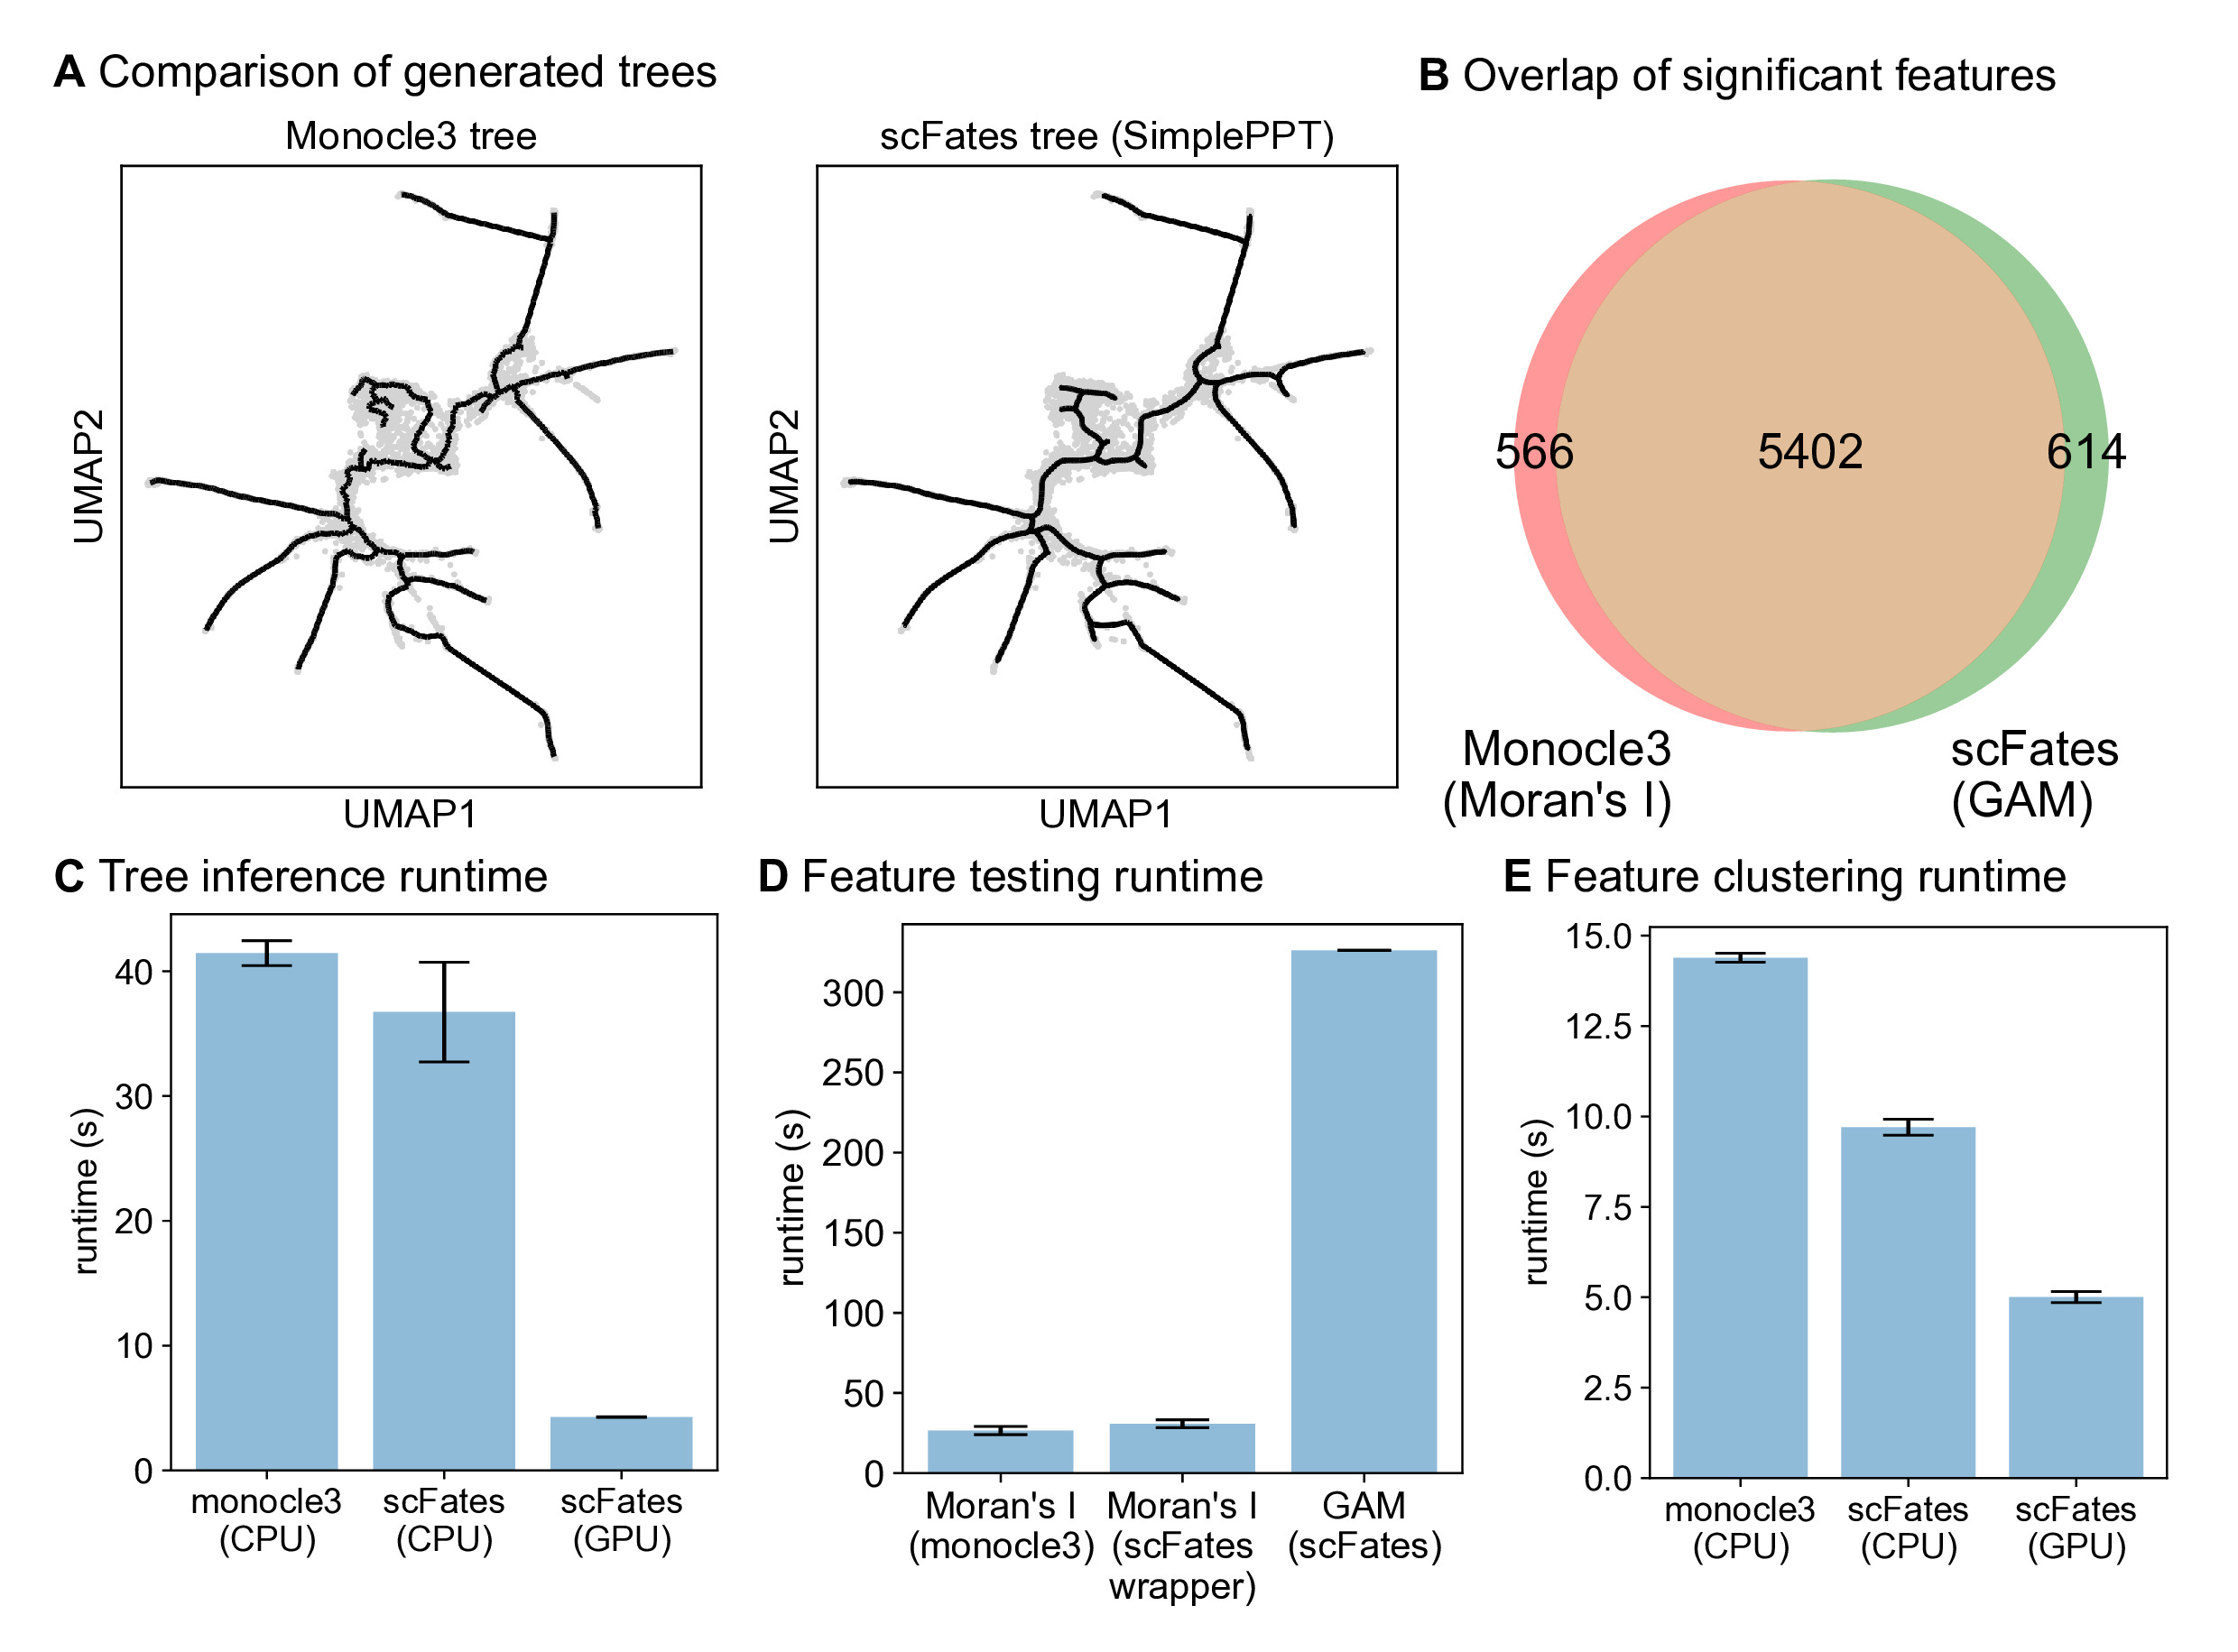

In [41]:
from IPython.display import Image
Image(filename=f'{fname}.jpg')